# Multiclass Classifier for TP53 Mutation Prediction
This notebook aims to predict mutations' variants in the TP53 protein and identify genes responsible for these mutations.

In [60]:
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest

### Dataset Manipulation & Creation

In [61]:
mutations  = pd.read_csv('data/OmicsSomaticMutations.csv')
mutations = mutations[mutations['HugoSymbol'] == 'TP53']
model = pd.read_csv('data/Model.csv')
expression = pd.read_csv('data/OmicsExpressionProteinCodingGenesTPMLogp1.csv')

/var/folders/9d/sqxp5kj56832p1mf59mk01gc0000gn/T/ipykernel_73207/341028324.py:1: DtypeWarning: Columns (22,50,56,57,58,59,61) have mixed types. Specify dtype option on import or set low_memory=False.
  mutations  = pd.read_csv('data/OmicsSomaticMutations.csv')


In [62]:
#rename the first column of expression to 'ModelID'
expression.rename(columns={expression.columns[0]: 'ModelID'}, inplace=True)
mutations['VariantType'] = mutations['VariantType'].astype('category')
# Convert the 'VariantType' column to categorical
category_mapping = dict(enumerate(mutations['VariantType'].cat.categories))
print(category_mapping)
mutations['VariantType'] = mutations['VariantType'].cat.codes

{0: 'SNV', 1: 'deletion', 2: 'insertion', 3: 'substitution'}


In [63]:
merged = pd.merge(expression, mutations[['ModelID', 'HugoSymbol', 'VariantType']], on='ModelID', how='left')
merged['VariantType'] = merged['VariantType'].fillna(4)
#change the type of the 'VariantType' column to int
merged['VariantType'] = merged['VariantType'].astype(int)
# create a boolean column 'Mutated' which is 1 if 'HugoSymbol' is not null and 0 if it is null
merged['Mutated'] = np.where(merged['HugoSymbol'].isnull(), 0, 1) 

### EDA

In [64]:
#print columns whose type is not float64 or int64
print(merged.select_dtypes(exclude=['float64']).columns)

Index(['ModelID', 'HugoSymbol', 'VariantType', 'Mutated'], dtype='object')


Mutated
1    0.61727
0    0.38273
Name: proportion, dtype: float64
VariantType
0    0.519220
4    0.382730
1    0.069638
2    0.018384
3    0.010028
Name: proportion, dtype: float64


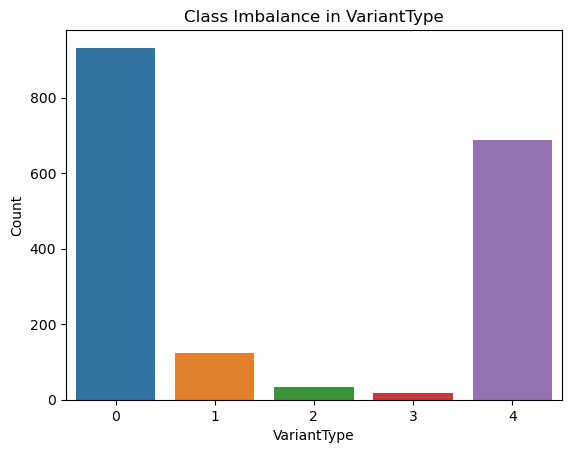

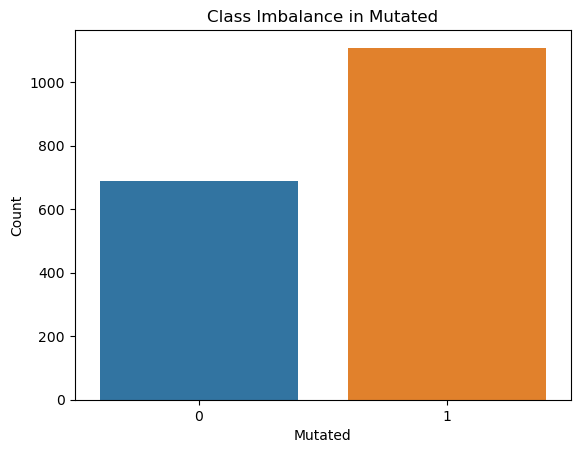

In [65]:
# check for class imbalance
print(merged['Mutated'].value_counts(normalize=True))
# check for class imbalance in the VariantType column
print(merged['VariantType'].value_counts(normalize=True))
# check for class imbalance in the VariantType column with a plot
sns.countplot(x='VariantType', data=merged)
plt.title('Class Imbalance in VariantType')
plt.xlabel('VariantType')
plt.ylabel('Count')
plt.show()

# check for class imbalance in the Mutated column with a plot
sns.countplot(x='Mutated', data=merged)
plt.title('Class Imbalance in Mutated')
plt.xlabel('Mutated')
plt.ylabel('Count')
plt.show()



In [66]:
merged_mod= merged.drop(columns=['ModelID', 'HugoSymbol', 'Mutated'])
variants = merged_mod['VariantType']

In [67]:
def detect_and_handle_outliers_isolation_forest(data, contamination=0.05, random_state=42, tp53_vec=None,variants_vec=None):
    # Create a copy of the data
    df = data.copy()
    
    # Select only numeric columns for outlier detection
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    X = df[numeric_cols].values
    
    # Fit the Isolation Forest model
    print(f"Fitting Isolation Forest with contamination={contamination}...")
    iso_forest = IsolationForest(contamination=contamination, random_state=random_state, n_jobs=-1)
    outlier_predictions = iso_forest.fit_predict(X)
    
    # Find indices of outliers (outlier_predictions == -1)
    outlier_indices = np.where(outlier_predictions == -1)[0]
    outlier_count = len(outlier_indices)
    
    print(f"Detected {outlier_count} outliers ({outlier_count/len(df)*100:.2f}% of the data)")
    # If there are outliers, examine their characteristics
    if outlier_count > 0:
        # Compare the distribution of normal vs outlier samples
        final_df= df.drop(outlier_indices)
        tp53_vec = tp53_vec.drop(outlier_indices) if tp53_vec is not None else tp53_vec
        variants_vec = variants_vec.drop(outlier_indices) if variants_vec is not None else variants_vec
    return final_df, outlier_indices, tp53_vec, variants_vec

In [68]:
merged_mod, outlier_indices, tp53,variants= detect_and_handle_outliers_isolation_forest(
        merged_mod,
        contamination=0.05,
        tp53_vec=None,
        variants_vec=variants
    )

Fitting Isolation Forest with contamination=0.05...
Detected 90 outliers (5.01% of the data)


### PCA Analysis

In [69]:
pca = PCA(n_components=128)
pca_input = merged_mod
#standardize the data
scaler = StandardScaler()
pca_input = scaler.fit_transform(pca_input)
#fit the pca model
pca.fit(pca_input)
#transform the data
pca_result = pca.transform(pca_input)
#convert to dataframe
pca_result = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

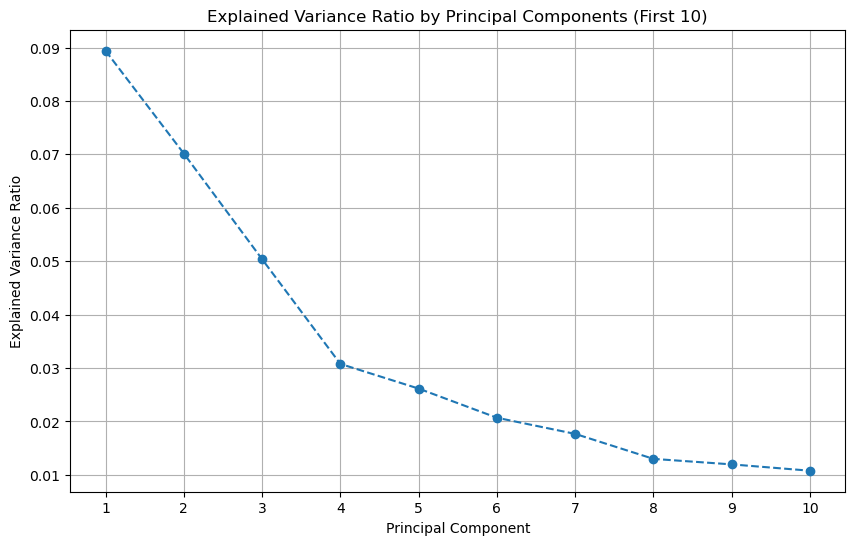

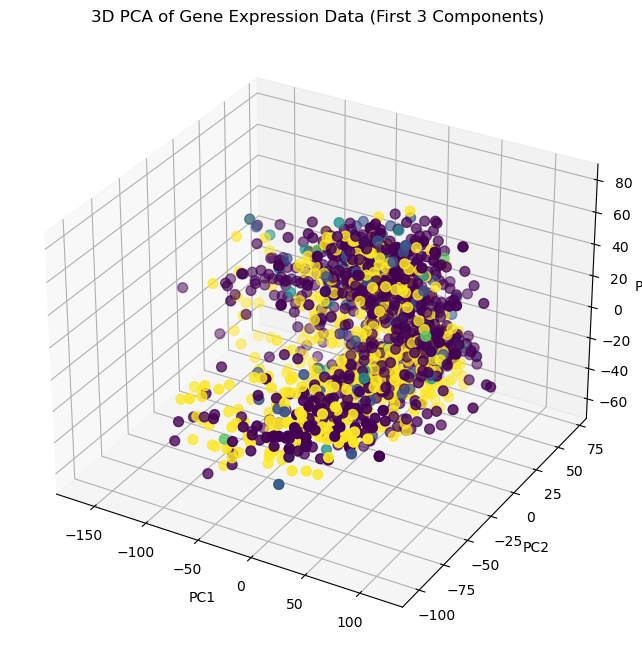

In [70]:
# plot the explained variance ratio for the first 10 components
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), pca.explained_variance_ratio_[:10], marker='o', linestyle='--')
plt.title('Explained Variance Ratio by Principal Components (First 10)')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

# plot the PCA results in 3D using the first three principal components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_result['PC1'], pca_result['PC2'], pca_result['PC3'], c= variants,cmap='viridis', s=50)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('3D PCA of Gene Expression Data (First 3 Components)')
plt.show()


### No particular clusterization emerges, the only thing we can say is that the first components are the most important as they possess the most variance

### Given the analysis done for the binary classification task we can do the same filtration of the columns and proceed with the classification task

In [71]:

genes_to_filter = [
    'CDKN1A', 'ABCA12', 'NTPCR', 'PGPEP1', 'RNF19B', 'LCE1E', 'EPN3', 'SCN4B', 'ARVCF', 'FCHO2', 'PANK2', 'TMEM8B',
    'RRM2B', 'ANKRA2', 'ORAI3', 'PLCL2', 'SAC3D1', 'LIMK2', 'FBXO32', 'SCRIB', 'BHLHE40', 'FCHSD2', 'PAQR7', 'TP53',
    'MDM2', 'CCNG1', 'PRKAB1', 'PMAIP1', 'SYTL1', 'LRP1', 'FHL2', 'SEMA3B', 'BMP7', 'FLRT2', 'PCBP4', 'TP53I11',
    'SUSD6', 'CYFIP2', 'PTP4A1', 'PRDM1', 'TNFRSF10A', 'MCC', 'HES2', 'SLC25A45', 'BORCS7', 'GBE1', 'PERP', 'TRAK1',
    'GDF15', 'DRAM1', 'SESN2', 'RAP2B', 'TNFRSF10D', 'NUPR1', 'KCNN4', 'SLC44A5', 'BTBD10', 'GPC1', 'PLLP', 'TRIP6',
    'BTG2', 'FBXO22', 'SLC30A1', 'RRAD', 'TSPAN11', 'PARD6G', 'KLHDC7A', 'SLC4A11', 'BTG3', 'HES1', 'POU3F1', 'TSGA10',
    'DDB2', 'ISCU', 'SPATA18', 'ZNF219', 'VWCE', 'PHPT1', 'LMNA', 'SLC9A1', 'C17orf89', 'HRAS', 'PPFIBP1', 'UNC5B',
    'GADD45A', 'PHLDA3', 'TGFA', 'ZNF337', 'DDIT4', 'PIDD1', 'MLF2', 'STAT3', 'CAPN2', 'HSD17B3', 'PPM1J', 'UQCC1',
    'PLK3', 'SERPINB5', 'TLR3', 'ACTA2', 'RAD51C', 'PML', 'MR1', 'STK17A', 'CASP6', 'ICOSLG', 'PPP4R3A', 'VDR',
    'TIGAR', 'SERTAD1', 'TM7SF3', 'EDN2', 'SERPINE1', 'PTPRE', 'MYO6', 'STX6', 'CATSPERG', 'IGFBP7', 'PTAFR', 'YPEL3',
    'RPS27L', 'TRAF4', 'TMEM68', 'ALOX5', 'TNFAIP8', 'PVRL4', 'NEFL', 'TP73', 'CAV1', 'IL1B', 'RALGDS', 'ZNF195',
    'TNFRSF10B', 'TRIM22', 'WDR63', 'ARHGEF3', 'TSKU', 'RETSAT', 'NKAIN4', 'TRIM32', 'CCNK', 'ISYNA1', 'RBM38', 'ZNF385A',
    'TRIAP1', 'CES2', 'ZNF561', 'CERS5', 'PCNA', 'REV3L', 'PCLO', 'TRIM38', 'CFLAR', 'JAG1', 'RGL1', 'ZNF488',
    'ZMAT3', 'CMBL', 'ZNF79', 'DDR1', 'ACYP2', 'RNASE7', 'PDE4C', 'TRIM5', 'CGB7', 'KRT8', 'RGS20',
    'BAX', 'FBXW7', 'ASCC3', 'DHRS3', 'APAF1', 'SFN', 'PGAP1', 'TYMSOS', 'CHST14', 'KSR1', 'RHOC',
    'PGF', 'HSPA4L', 'ACER2', 'DUSP14', 'APOBEC3H', 'TNFRSF10C', 'PLCXD2', 'AKAP9', 'COBLL1', 'LACC1', 'RPS19',
    'POLH', 'KITLG', 'ANXA4', 'E2F7', 'BCL2L1', 'TRIML2', 'PLEKHF1', 'CCDC51', 'CPEB2', 'LPXN', 'SARS',
    'PPM1D', 'SLC12A4', 'APOBEC3C', 'EPS8L2', 'BCL6', 'VCAN', 'PLTP', 'CDH8', 'CPSF4', 'LRPAP1', 'SCIN',
    'SULF2', 'ATF3', 'ASTN2', 'FAM210B', 'BLCAP', 'ADCK3', 'PLXNB1', 'DUSP11', 'DNAJB2', 'MFAP3L', 'SCN3B',
    'XPC', 'BBC3', 'CD82', 'GLS2', 'C17orf82', 'AK3', 'PLXNB2', 'GCC2', 'DOCK8', 'MKNK2', 'SDC4',
    'AEN', 'CCDC90B', 'CDIP1', 'GPX1', 'COL7A1', 'ALDH1A3', 'PRKAB2', 'METTL8', 'DUSP5', 'MON2', 'SDPR',
    'BLOC1S2', 'DYRK3', 'CPE', 'GRHL3', 'CPEB4', 'BBS2', 'PRKX', 'PPP1R3C', 'DUSP7', 'MRPL49', 'SMAD3',
    'FAS', 'EDA2R', 'CSF1', 'HHAT', 'CSNK1G1', 'BTG1', 'PRODH', 'STEAP3', 'EBI3', 'MYBPHL', 'SNX2',
    'GPR87', 'EPHA2', 'DCP1B', 'IGDCC4', 'DGKA', 'CEL', 'PTPRU', 'ABHD4', 'EFNB1', 'MYLK', 'SOCS4',
    'NINJ1', 'FAM13C', 'ENC1', 'IKBIP', 'FAM49A', 'CLCA2', 'RGMA', 'ABTB2', 'EI24', 'MYOF', 'TAB3',
    'PLK2', 'FAM198B', 'FOSL1', 'LAPTM5', 'FAM84B', 'CLDN1', 'RGS16', 'ADGRG1', 'EML2', 'NFKBIA', 'TCAIM',
    'PSTPIP2', 'FAM212B', 'FUCA1', 'MAST4', 'GNAI1', 'CLP1', 'RND3', 'AIFM2', 'ENPP2', 'NHLH2', 'TEP1',
    'SESN1', 'FDXR', 'IER5', 'MICALL1', 'INPP1', 'CROT', 'RNF144B', 'AMOTL1', 'ETV7', 'NLRP1', 'TET2',
    'TP53I3', 'LIF', 'PADI4', 'NOTCH1', 'ITGA3', 'CYP4F3', 'S100A2', 'AMZ2', 'FAM196A', 'NYNRIN', 'TEX9',
    'TP53INP1', 'NADSYN1', 'PANK1', 'RABGGTA', 'KRT15', 'DAPK1', 'SCN2A', 'ARC', 'FAM98C', 'P3H2', 'TMEM63B'
]

merged_mod.columns = merged_mod.columns.str.replace(r'\s*\(.*?\)', '', regex=True)
mod_data = merged_mod[merged_mod.columns[merged_mod.columns.isin(genes_to_filter)]]

In [72]:
X = mod_data
y = variants
#perform upsampling using smote
smote = SMOTE(random_state=42, sampling_strategy='auto')
X, y = smote.fit_resample(X, y)
#split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model 1: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.59      0.69       175
           1       0.78      0.99      0.88       175
           2       0.95      1.00      0.98       167
           3       0.98      1.00      0.99       166
           4       0.85      0.81      0.83       194

    accuracy                           0.88       877
   macro avg       0.88      0.88      0.87       877
weighted avg       0.88      0.88      0.87       877



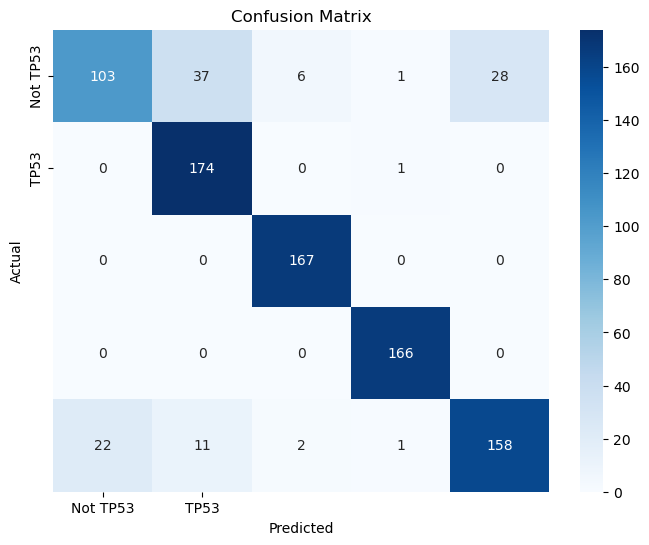

In [73]:
#fit the model
lg_model = LogisticRegression(max_iter=10000)
lg_model.fit(X_train, y_train)
#predict the test set
y_pred = lg_model.predict(X_test)
#predict the probabilities
y_pred_proba = lg_model.predict_proba(X_test)[:, 1]
#calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
#calculate the classification report
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not TP53', 'TP53'], yticklabels=['Not TP53', 'TP53'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Model 2: Random Forest 

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       175
           1       0.94      0.96      0.95       175
           2       0.99      0.99      0.99       167
           3       0.99      0.99      0.99       166
           4       0.90      0.84      0.87       194

    accuracy                           0.92       877
   macro avg       0.93      0.93      0.93       877
weighted avg       0.92      0.92      0.92       877



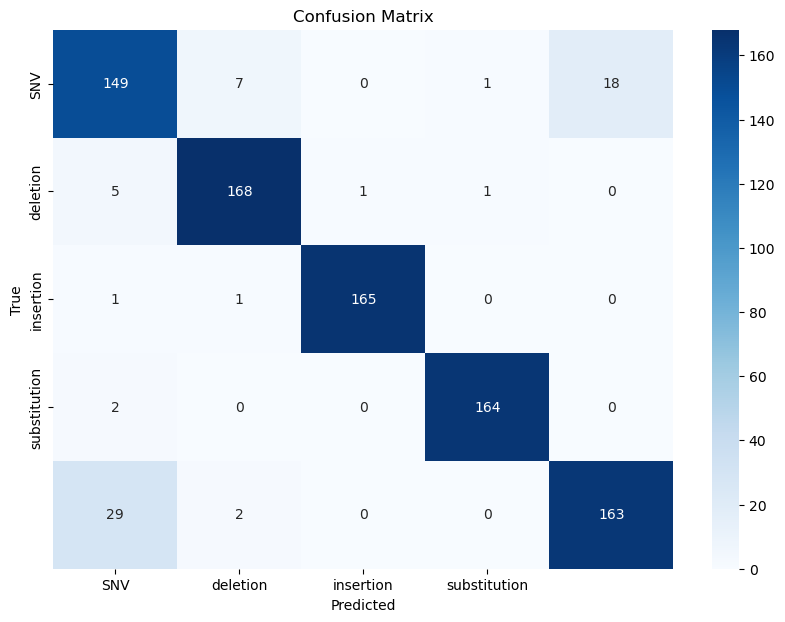

In [74]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
#predict the test set
y_pred = rf.predict(X_test)
#predict the probabilities of the test set
y_pred_proba = rf.predict_proba(X_test)
report = classification_report(y_test, y_pred)
print(report)
cm = confusion_matrix(y_test, y_pred)
#plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_mapping.values(), yticklabels=category_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Model 3: Xgboost

/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:15:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.83      0.81      0.82       175
           1       0.90      0.96      0.93       175
           2       0.99      0.99      0.99       167
           3       0.99      0.99      0.99       166
           4       0.90      0.87      0.88       194

    accuracy                           0.92       877
   macro avg       0.92      0.92      0.92       877
weighted avg       0.92      0.92      0.92       877



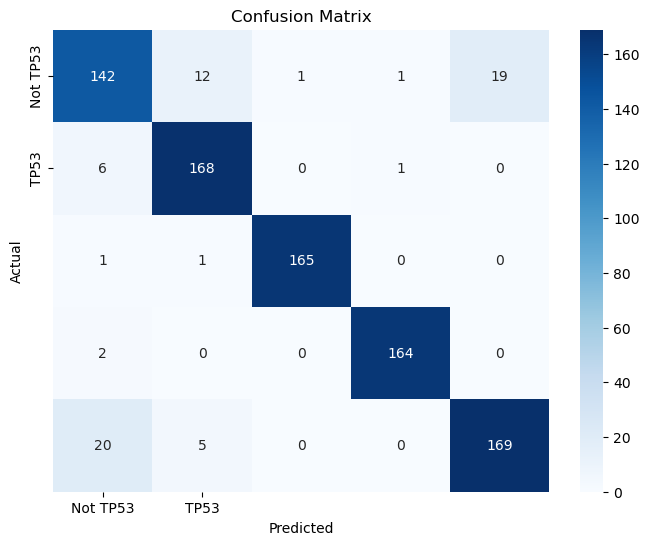

In [75]:
xgb_model = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, scale_pos_weight=1,random_state=42)
xgb_model.fit(X_train, y_train)
#predict the test set
y_pred = xgb_model.predict(X_test)
#predict the probabilities
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
#calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
#calculate the classification report
report = classification_report(y_test, y_pred)
print(report)
#calculate the roc_auc score
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not TP53', 'TP53'], yticklabels=['Not TP53', 'TP53'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

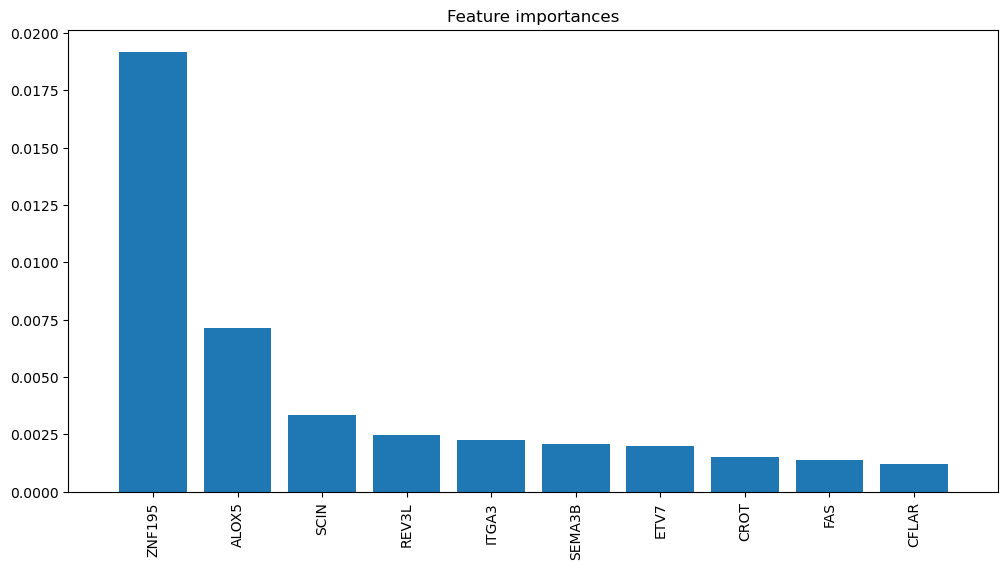

In [76]:
#feature importance
importances = (xgb_model.feature_importances_)[:10]
indices = np.argsort(importances)[::-1]
# Print the feature ranking
plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), X_train.columns[indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.show()

- ZNF195 (highest importance): 
  Zinc Finger Protein 195 - A transcription regulator that may be involved in gene expression control. Its dramatic importance suggests mutations in different regions of TP53 may strongly influence transcriptional regulation networks.

- ALOX5: 
  Arachidonate 5-Lipoxygenase - An enzyme involved in inflammatory responses and leukotriene biosynthesis. Its high importance suggests different classes of TP53 mutations may distinctly affect inflammatory signaling pathways.

- SCIN: 
  Scinderin - An actin-severing protein involved in cytoskeletal remodeling and exocytosis. This suggests different TP53 mutation classes may have varying effects on cellular architecture and secretory processes.

- REV3L: 
  DNA Polymerase Zeta Catalytic Subunit - Involved in translesion DNA synthesis and DNA damage repair. Different TP53 mutation classes likely have distinct effects on DNA repair mechanisms.

- ITGA3: 
  Integrin Subunit Alpha 3 - A cell surface adhesion receptor mediating cell-matrix interactions. Different classes of TP53 mutations may distinctly affect cell adhesion and migration behaviors.

- SEMA3B: 
  Semaphorin 3B - A secreted protein with tumor suppressor properties that can induce apoptosis. Different TP53 mutation classes may interact differently with other tumor suppressor pathways.

- ETV7: 
  ETS Variant Transcription Factor 7 - A transcription factor that can act as an oncogene. Different TP53 mutation classes may have varying effects on oncogenic transcription programs.

- CROT: 
  Carnitine O-Octanoyltransferase - Involved in lipid metabolism and fatty acid beta-oxidation. This suggests different TP53 mutation classes may distinctly affect metabolic reprogramming.

- FAS: 
  Fas Cell Surface Death Receptor - A critical mediator of programmed cell death. Different TP53 mutation classes likely have varying impacts on apoptotic pathways.

- CFLAR: 
  CASP8 And FADD Like Apoptosis Regulator - Regulates extrinsic apoptosis signaling. Along with FAS, this further highlights how different TP53 mutation classes may distinctly affect cell death processes.

Biological interpretation of this plot:

The significant dominance of ZNF195 suggests that transcriptional regulation may be a key distinguishing factor between different classes of TP53 mutations.

The diverse cellular processes represented (transcriptional regulation, inflammation, cytoskeletal organization, DNA repair, cell adhesion, and apoptosis) reflect how different TP53 mutation classes can have wide-ranging but distinct effects.

The presence of multiple apoptosis regulators (SEMA3B, FAS, CFLAR) suggests that variation in cell death control is an important distinguishing feature between TP53 mutation classes.

The model may be identifying gene expression signatures specific to mutations in different functional domains of TP53 (DNA-binding domain, transactivation domain, etc.), each affecting downstream pathways in distinct ways.